In [ ]:
# Link for download and environment setup requrements
import platform
import os
import sys
import pandas as pd
import seaborn as sns
from scipy.stats import shapiro
import numpy as np


display(platform.system())
file_download_link = 'https://data.ca.gov/dataset/3f08b68e-1d1a-4ba4-a07d-1ec3392ed191/resource/78a9d6ee-ec9a-4c25-ae34-5bac44010cb2/download/qcew_2016-2019.csv'
if os.name == 'nt':
    print(f'Please download your dataset here: {file_download_link}')
else:
    # If on another OS, use wget to download the CSV file directly
    !wget -O qcew_2016-2019.csv "$file_download_link" -o /dev/null
    print("File downloaded successfully as qcew_2016-2019.csv")
!{sys.executable} -m pip install imbalanced-learn delayed

'Darwin'

File downloaded successfully as qcew_2016-2019.csv


In [ ]:
# If using VSCode, don't run this cell
from google.colab import drive
drive.mount('/content/drive')

In [6]:
# Turn the dataset into a data frame
df = pd.read_csv('./qcew_2016-2019.csv')
print(f'The shape of the dataset is: {df.shape}')
df.head()

The shape of the dataset is: (1009955, 15)


,Area Type,Area Name,Year,Quarter,Ownership,NAICS Level,NAICS Code,Industry Name,Establishments,Average Monthly Employment,1st Month Emp,2nd Month Emp,3rd Month Emp,Total Wages (All Workers),Average Weekly Wages
0,County,Alameda County,2016,1st Qtr,Federal Government,2,1023,Financial Activities,1,10,10,10,10,359690.0,2767.0
1,County,Alameda County,2016,1st Qtr,Federal Government,2,1028,Public Administration,72,5174,5193,5143,5188,136068970.0,2023.0
2,County,Alameda County,2016,1st Qtr,Private,5,11121,Vegetable and Melon Farming,7,29,31,27,29,210934.0,560.0
3,County,Alameda County,2016,1st Qtr,Private,4,1114,Greenhouse and Nursery Production,7,52,61,64,31,748616.0,1107.0
4,County,Alameda County,2016,1st Qtr,Private,5,11142,Nursery and Floriculture Production,7,52,61,64,31,748616.0,1107.0


In [18]:
df.columns

Index(['Area Type', 'Area Name', 'Year', 'Quarter', 'Ownership', 'NAICS Level',
       'NAICS Code', 'Industry Name', 'Establishments',
       'Average Monthly Employment', '1st Month Emp', '2nd Month Emp',
       '3rd Month Emp', 'Total Wages (All Workers)', 'Average Weekly Wages'],
      dtype='object')

In [19]:
df.describe()

,Year,NAICS Level,Establishments,Average Monthly Employment,1st Month Emp,2nd Month Emp,3rd Month Emp,Total Wages (All Workers),Average Weekly Wages
count,1.009955e+06,1.009955e+06,1.009955e+06,1.009955e+06,1.009955e+06,1.009955e+06,1.009955e+06,1.009955e+06,1.009955e+06
mean,2.017506e+03,4.742008e+00,2.482561e+03,3.498097e+04,2.784764e+04,2.801089e+04,2.809293e+04,8.136866e+08,1.092761e+03
std,1.119452e+00,1.273100e+00,8.917906e+04,1.212335e+06,1.079614e+06,1.085457e+06,1.088328e+06,3.404081e+10,7.336131e+02
min,2.016000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.017000e+03,4.000000e+00,7.000000e+00,7.100000e+01,1.200000e+01,1.200000e+01,1.200000e+01,1.001182e+06,6.550000e+02
50%,2.018000e+03,5.000000e+00,2.000000e+01,3.030000e+02,1.490000e+02,1.500000e+02,1.490000e+02,4.946373e+06,9.560000e+02
75%,2.019000e+03,6.000000e+00,9.000000e+01,1.607000e+03,9.630000e+02,9.660000e+02,9.670000e+02,3.044671e+07,1.341000e+03
max,2.019000e+03,6.000000e+00,1.036382e+07,1.499311e+08,1.495277e+08,1.502603e+08,1.500053e+08,8.769109e+12,2.950200e+04


In [ ]:
#Lots of data points, maybe we can drop the older years
print("Number of datapoints from 2018-2019: ", df.loc[df['Year'] == 2019].shape[0] + df.loc[df['Year'] == 2018].shape[0])

Number of datapoints from 2018-2019:  506913


In [9]:
#Checking what Area Types we have
print(f'Here are the area types we have: {df['Area Type'].unique().tolist()}')

Here are the area types we have: ['County', 'California - Statewide', 'United States']


In [11]:
#We want to focus on the county level, lets ensure there are enough datapoints to drop the rest
print("Number of datapoints that are just counties:", df.loc[(df['Area Type'] == 'County') & ((df['Year'] == 2019) | (df['Year'] == 2018))].shape[0])

Number of datapoints that are just counties: 441540


In [12]:
#Since there may be overlap between Quarters or the Annual datapoints, lets only use Annual, lets see if there are enough datapoints for that
print("Number of datapoints that are only Annual:", df.loc[(df['Area Type'] == 'County') & ((df['Year'] == 2019) | (df['Year'] == 2018)) & (df['Quarter'] == 'Annual')].shape[0])

Number of datapoints that are only Annual: 89255


In [13]:
#Lets see how many industry names there are, we may want to reduce this through economic sectors
print(f'Here are all the industry names: {df['Industry Name'].unique().tolist()}')
print(f'Number of industry names: {df['Industry Name'].nunique()}')

Here are all the industry names: ['Financial Activities', 'Public Administration', 'Vegetable and Melon Farming', 'Greenhouse and Nursery Production', 'Nursery and Floriculture Production', 'Support Activities for Crop Production', 'New Single-Family Housing Construction', 'Residential Remodelers', 'Nonresidential Building Construction', 'Commercial Building Construction', 'Other Heavy Construction', 'Specialty Trade Contractors', 'Poured Concrete Structure Contractors', 'Other Schools and Instruction', 'All Other Schools and Instruction', 'Textile and Fabric Finishing Mills', 'Textile Product Mills', 'Textile Furnishings Mills', 'All Other Textile Product Mills', 'Cut and Sew Apparel Contractors', "Men's and boys' cut and sew apparel mfg.", 'Apparel accessories and other apparel mfg.', 'Other Leather Product Manufacturing', 'Millwork', 'Paper bag and coated and treated paper mfg.', 'Other Converted Paper Product Mfg', 'Support Activities for Printing', 'Petroleum & Coal Products Manuf

In [25]:
#Check for missing values
df.isnull().sum()

Area Type                     0
Area Name                     0
Year                          0
Quarter                       0
Ownership                     0
NAICS Level                   0
NAICS Code                    0
Industry Name                 0
Establishments                0
Average Monthly Employment    0
1st Month Emp                 0
2nd Month Emp                 0
3rd Month Emp                 0
Total Wages (All Workers)     0
Average Weekly Wages          0
dtype: int64

In [53]:
#Drop some data points for faster visualization
dfTemp = df.loc[(df['Area Type'] == 'County') & ((df['Year'] == 2019) | (df['Year'] == 2018)) & (df['Quarter'] == 'Annual')]

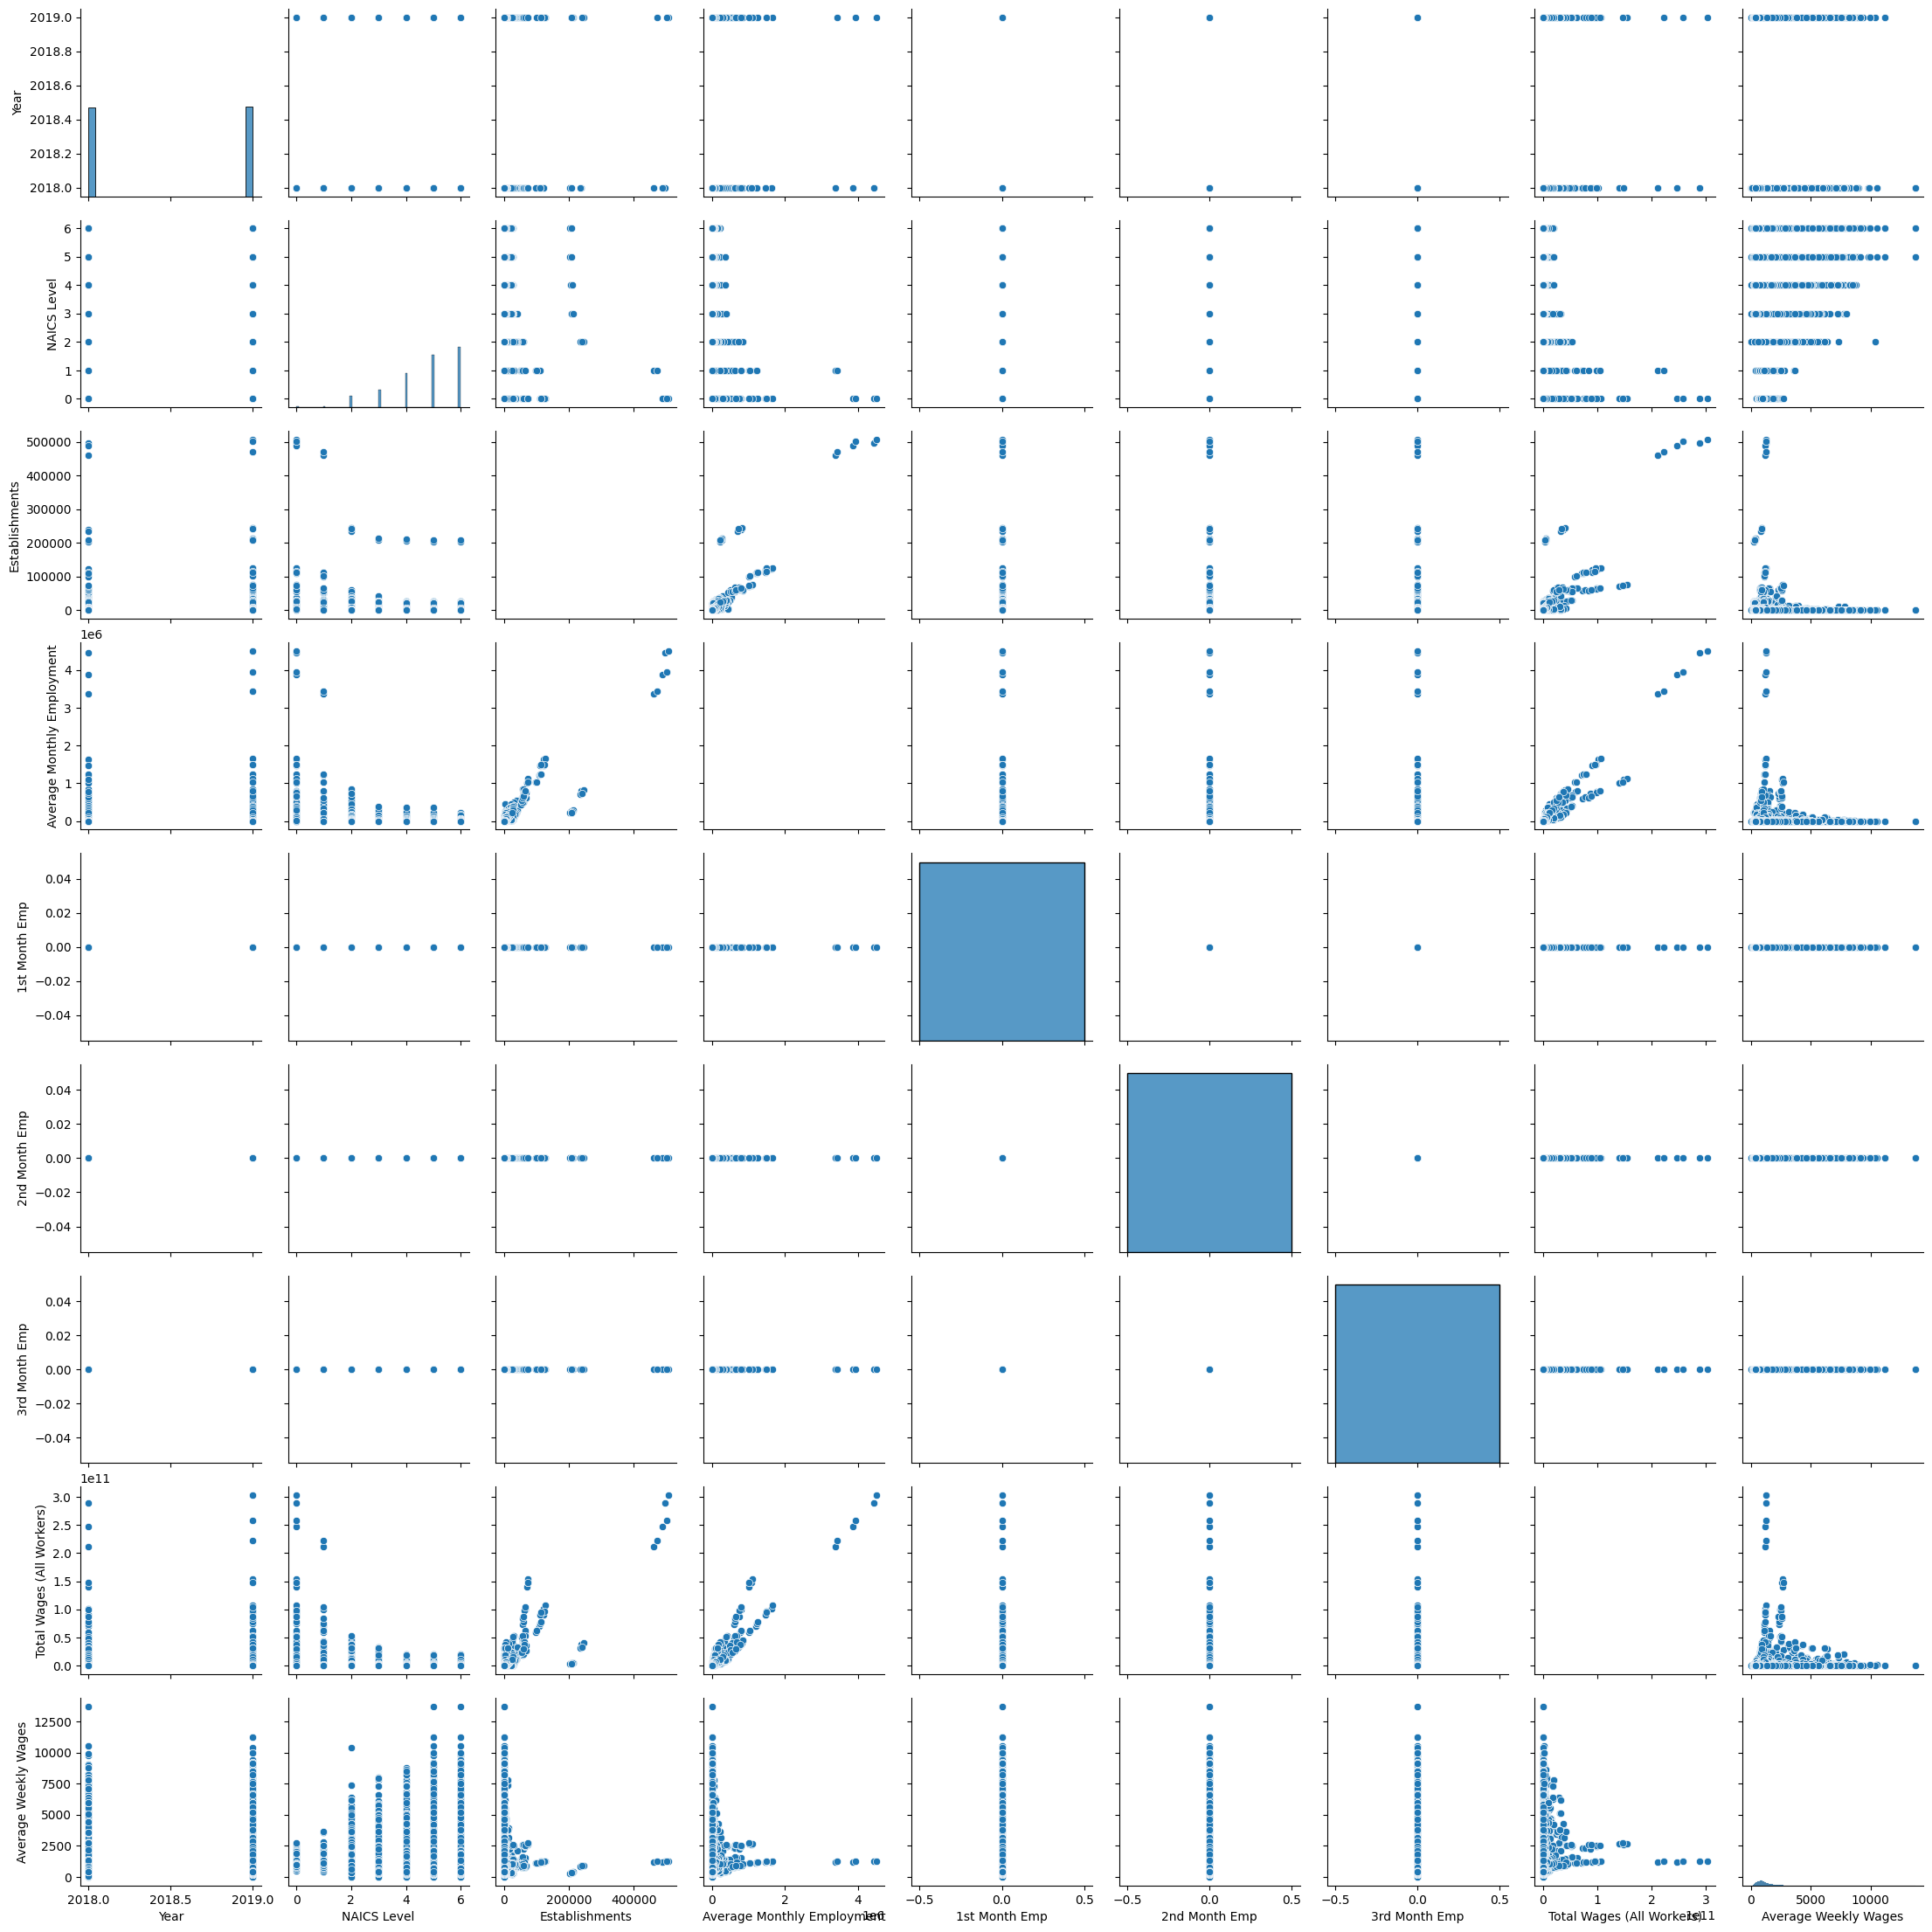

In [14]:
sns.pairplot(dfTemp)

In [63]:
#Drop categorical data
dfNonCategorical = dfTemp.copy(deep = True)
dfNonCategorical.drop(['1st Month Emp','2nd Month Emp','3rd Month Emp','Area Type','Area Name','Year','Quarter','Ownership','NAICS Level','NAICS Code','Industry Name'],axis=1,inplace=True)

<Axes: >

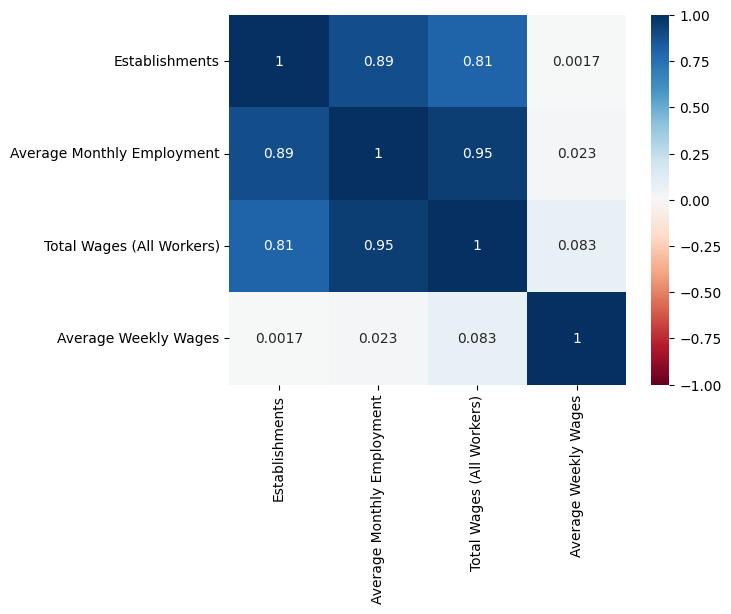

In [64]:
corr = dfNonCategorical.corr()
sns.heatmap(corr, vmin = -1, vmax = 1, center = 0, annot = True, cmap = 'RdBu')

In [65]:
for columnname in dfNonCategorical:
    print(columnname)
    print(shapiro(dfNonCategorical[columnname]))

Establishments
ShapiroResult(statistic=np.float64(0.023661410219759094), pvalue=np.float64(2.6148748874841756e-180))
Average Monthly Employment
ShapiroResult(statistic=np.float64(0.036656412023569174), pvalue=np.float64(7.648368176197863e-180))
Total Wages (All Workers)
ShapiroResult(statistic=np.float64(0.03690291414377811), pvalue=np.float64(7.806660267595417e-180))
Average Weekly Wages
ShapiroResult(statistic=np.float64(0.7850183132652453), pvalue=np.float64(1.6024122026725113e-131))


c:\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 89255.
  res = hypotest_fun_out(*samples, **kwds)


In [66]:
#Check data types of columns
df.dtypes

Area Type                      object
Area Name                      object
Year                            int64
Quarter                        object
Ownership                      object
NAICS Level                     int64
NAICS Code                     object
Industry Name                  object
Establishments                  int64
Average Monthly Employment      int64
1st Month Emp                   int64
2nd Month Emp                   int64
3rd Month Emp                   int64
Total Wages (All Workers)     float64
Average Weekly Wages          float64
dtype: object